##### Test by independent Gillespie simulation

In [60]:
import memo_py as me
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import scipy.stats as stats
import copy

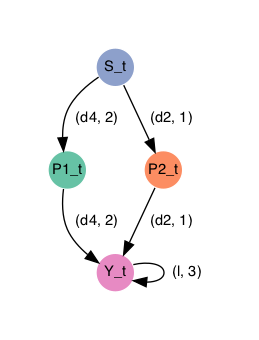

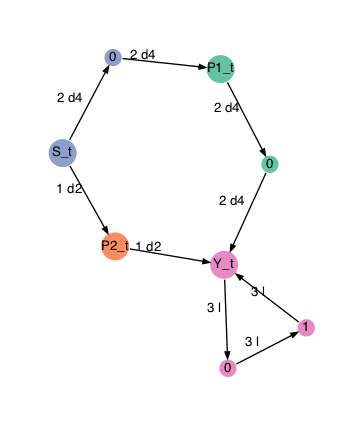

In [61]:
# test is based on the following specific network
t = [
    {'start': 'S_t', 'end': 'P1_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': int(4/2)},
    {'start': 'P1_t', 'end': 'Y_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': int(4/2)},

    {'start': 'S_t', 'end': 'P2_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': int(2/2)},
    {'start': 'P2_t', 'end': 'Y_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': int(2/2)},

    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ]

# multigraph version (not yet implemented; seems to work on hidden layer but not on main layer image)
# t = [
#     {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': 4},
#     {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': 2},
#     {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
#     ]

net = me.Network('net_test_2')
net.structure(t)

me.plots.net_main_plot(net)
me.plots.net_hidden_plot(net)

##### Gillespie simulations (independent / framework external)

In [62]:
def gill_indep_test_2(initial_state, time_values, d4, d2, l, num_iter):
    # initialisation
    res = np.zeros((num_iter, 8, time_values.shape[0]))
    
    for i in range(num_iter):
        time_current = time_values[0]
        time_max = time_values[-1]
        cell_state = np.zeros(8)
        cell_state = copy.deepcopy(initial_state)
        
#         print('iter: ', i)
#         print('time_current: ', time_current)
#         print('time_max: ', time_max)
#         print('cell_state: ', cell_state)
        
        while time_current <= time_max:
            # reaction propensities
            reac_props = np.array([
                # NOTE: division by 2 in the diff channels is only due to
                # current workaround for multigraphs (with P intermediate nodes)
                
                # differentiation d4 channel
                4.0/2 * d4 * cell_state[0], # d from Xcentric to X0
                4.0/2 * d4 * cell_state[1], # d from X0 to X1
                4.0/2 * d4 * cell_state[2], # d from X1 to X2
                4.0/2 * d4 * cell_state[3], # d from X2 to Ycentric
                
                # differentiation d2 channel
                2.0/2 * d2 * cell_state[0], # d from Xcentric to X0
                2.0/2 * d2 * cell_state[4], # d from X0 to X1
                
                # division
                3.0 * l * cell_state[5], # l from Ycentric to Y0
                3.0 * l * cell_state[6], # l from Y0 to Y1
                3.0 * l * cell_state[7], # l from Y1 to Ycentric
            ])
#             print('\n while start')
#             print('reac_props: ', reac_props)

            # draw exponential random time for next reaction
            total_prop = np.sum(reac_props)
            dt = np.random.exponential(1.0/total_prop)
            
#             print('total_prop: ', total_prop)
#             print('dt: ', dt)

            # save cell state results for relevant time points
            for ind in np.where((time_values >= time_current) 
                                & (time_values < time_current + dt))[0]:
                res[i, :, ind] = copy.deepcopy(cell_state).reshape((1,8))
            
#             print('res: ', res)
            
            # draw which reaction takes place
            reac_probs = reac_props/np.sum(reac_props)
            reac_rand = np.random.choice(reac_props.shape[0], p=reac_probs)
            
#             print('reac_probs: ', reac_probs)
#             print('reac_rand: ', reac_rand)

            # update cell state according to selected reaction
            # differentiation d4 channel
            if reac_rand==0:
                cell_state[0] += -1.0
                cell_state[1] += +1.0
            elif reac_rand==1:
                cell_state[1] += -1.0
                cell_state[2] += +1.0
            elif reac_rand==2:
                cell_state[2] += -1.0
                cell_state[3] += +1.0
            elif reac_rand==3:
                cell_state[3] += -1.0
                cell_state[5] += +1.0
                
            # differentiation d2 channel
            elif reac_rand==4:
                cell_state[0] += -1.0
                cell_state[4] += +1.0
            elif reac_rand==5:
                cell_state[4] += -1.0
                cell_state[5] += +1.0 

            # division
            elif reac_rand==6:
                cell_state[5] += -1.0
                cell_state[6] += +1.0
            elif reac_rand==7:
                cell_state[6] += -1.0
                cell_state[7] += +1.0
            elif reac_rand==8:
                cell_state[7] += -1.0
                cell_state[5] += +2.0
            else:
                print('error')

            # update current time by delta t
            time_current += dt
            
#             print('cell_state: ', cell_state)
#             print('time_current: ', time_current)
#             print('\n')
    
    # sum hidden states to get observable layer
    res_obs = np.zeros((num_iter, 2, time_values.shape[0]))
    res_obs[:, 0, :] = np.sum(res[:, (0,1,2,3,4), :], axis=1)
    res_obs[:, 1, :] = np.sum(res[:, (5,6,7), :], axis=1)
    return res_obs

In [63]:
# order of the variables of the hidden layer
# 0,1,2,3,4: X centric, X diff4 0, X diff4 1, X diff4 2, X diff2 0, 
# 5,6,7: Y centric, Y div 0, Y div 1
initial_values = np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
d4 = 0.06
d2 = 0.08
l = 0.06
num_iter = 50000
print(time_values)

# save result as external simulation results
sim_res_ext = gill_indep_test_2(initial_values, time_values, d4, d2, l, num_iter)

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46. 48. 50. 52. 54.]


In [64]:
print(sim_res_ext.shape)

(50000, 2, 28)


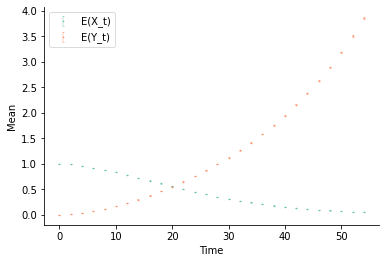

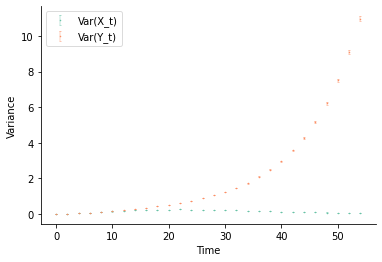

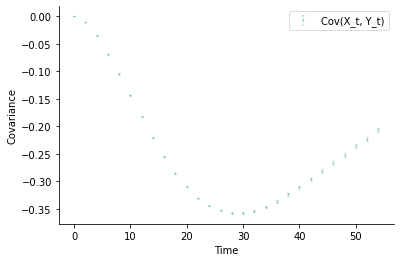

In [65]:
data_ext = me.Data('data_test_2_external')
data_ext.load(['X_t', 'Y_t'], time_values, sim_res_ext, 
              bootstrap_samples=1000, basic_sigma=1/num_iter)

me.plots.data_mean_plot(data_ext)
me.plots.data_variance_plot(data_ext)
me.plots.data_covariance_plot(data_ext)

##### Gillespie simulations (framework)

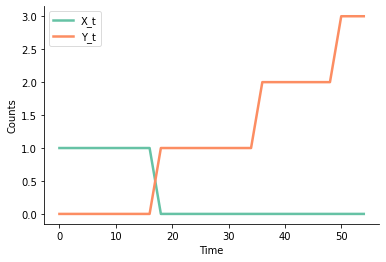

In [48]:
# compute Gillespie simulation with the framework
t = [
    {'start': 'S_t', 'end': 'P1_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': int(4/2)},
    {'start': 'P1_t', 'end': 'Y_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': int(4/2)},

    {'start': 'S_t', 'end': 'P2_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': int(2/2)},
    {'start': 'P2_t', 'end': 'Y_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': int(2/2)},

    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ]

initial_values = {'S_t': 1, 'Y_t': 0, 'P1_t': 0, 'P2_t': 0}
theta_values = {'l': 0.06, 'd4': 0.06, 'd2': 0.08}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('S_t', 'P1_t', 'P2_t'), 'Y_t': ('Y_t', )}

net = me.Network('net_test_2')
net.structure(t)

sim = me.Simulation(net)
res = sim.simulate('gillespie', initial_values, theta_values, time_values, variables)

me.plots.sim_counts_plot(sim)

In [49]:
# create a data object from simulations for the estimation
num_iter = 50000

res_list = list()
for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', initial_values, theta_values, time_values, variables)[1])

sim_res_int = np.array(res_list)

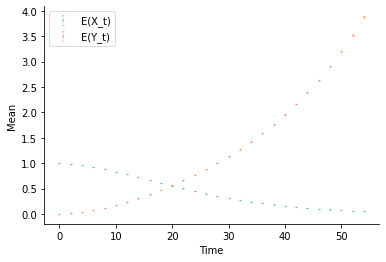

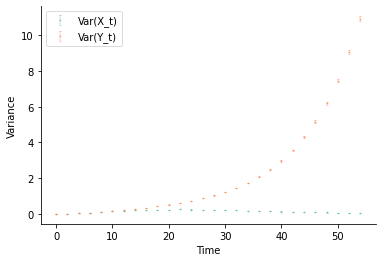

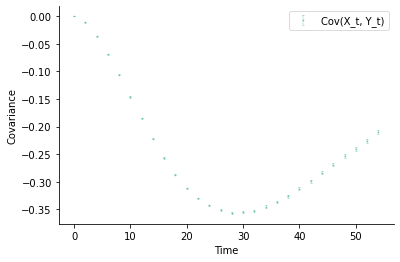

In [50]:
data_int = me.Data('data_test_2_internal')
data_int.load(['X_t', 'Y_t'], time_values, sim_res_int, 
              bootstrap_samples=1000, basic_sigma=1/num_iter)

me.plots.data_mean_plot(data_int)
me.plots.data_variance_plot(data_int)
me.plots.data_covariance_plot(data_int)

##### Moment simulations (framework)

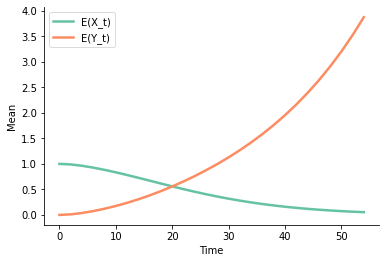

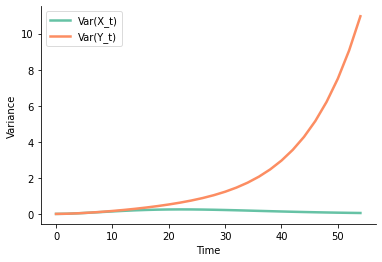

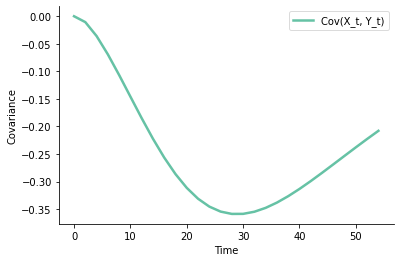

In [9]:
# multigraphs are not yet implemented, but maybe it just works:
t = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': 2},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ]

initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'l': 0.06, 'd4': 0.03, 'd2': 0.04}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

net = me.Network('net_test_2')
net.structure(t)

sim = me.Simulation(net)
sim_res_mom_mult = sim.simulate('moments', initial_values, theta_values, time_values, variables)

me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)
me.plots.sim_covariance_plot(sim)

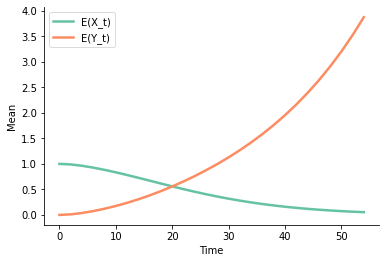

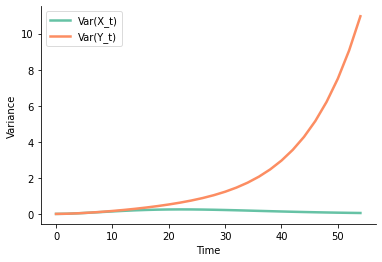

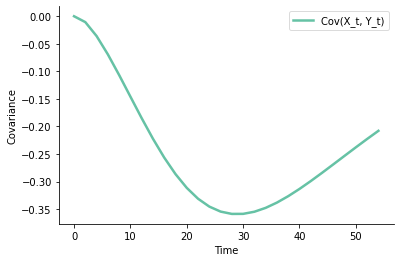

In [10]:
# current implementation way of two parallel channels
t = [
    {'start': 'S_t', 'end': 'P1_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': int(4/2)},
    {'start': 'P1_t', 'end': 'Y_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': int(4/2)},

    {'start': 'S_t', 'end': 'P2_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': int(2/2)},
    {'start': 'P2_t', 'end': 'Y_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': int(2/2)},

    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ]

initial_values = {'S_t': 1, 'Y_t': 0, 'P1_t': 0, 'P2_t': 0}
theta_values = {'l': 0.06, 'd4': 0.06, 'd2': 0.08}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('S_t', 'P1_t', 'P2_t'), 'Y_t': ('Y_t', )}

net = me.Network('net_test_2')
net.structure(t)

sim = me.Simulation(net)
sim_res_mom = sim.simulate('moments', initial_values, theta_values, time_values, variables)

me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)
me.plots.sim_covariance_plot(sim)

In [20]:
print(np.allclose(sim_res_mom[0], sim_res_mom_mult[0]))
print(np.allclose(sim_res_mom[1], sim_res_mom_mult[1]))
print(np.allclose(sim_res_mom[2], sim_res_mom_mult[2]))

True
True
True


##### Models for estimation

In [66]:
def make_model(steps_d4, steps_d2, steps_l):
    name = 'net_' + str(steps_d4) + '_' + str(steps_d2) + '_' + str(steps_l)

    t = [
    {'start': 'S_t', 'end': 'P1_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': int(steps_d4/2)},
    {'start': 'P1_t', 'end': 'Y_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': int(steps_d4/2)},

    {'start': 'S_t', 'end': 'P2_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': int(steps_d2/2)},
    {'start': 'P2_t', 'end': 'Y_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': int(steps_d2/2)},

    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': steps_l}
    ]

    s = {'initial_values': {'S_t': 1, 'Y_t': 0, 'P1_t': 0, 'P2_t': 0},
         'theta_bounds': {'d4': (0.0, 0.15), 'd2': (0.0, 0.15), 'l': (0.0, 0.15)}, 
         'variables': {'X_t': ('S_t', 'P1_t', 'P2_t'), 'Y_t': ('Y_t', )}
        }

    return (name, t, s)

models = [make_model(steps_d4, steps_d2, steps_l) for steps_d4 in [2, 4, 6]
                                                  for steps_d2 in [2, 4, 6]
                                                  for steps_l in range(1, 6)]
print(len(models))

45


##### Estimation of internal simulated data

In [51]:
d = {
# model set
'model_set': models,

# data/model settings
'data': data_int,
'mean_only': False, # True or False

# nested sampling settings
'nlive':                    250, # 250 # 1000
'tolerance':                0.1, # 0.1 (COARSE) # 0.05 # 0.01 (NORMAL)
'bound':                    'multi',
'sample':                   'unif'
}

est_res_int = me.select_models(d, parallel={'do':False})

45


In [52]:
net_names = [est.net.net_name for est in est_res_int]
model_probs = me.selection.compute_model_probabilities(est_res_int)
print(net_names.index('net_4_2_3')) # true model
print(net_names.index('net_2_4_3')) # symmetric true model

17
7


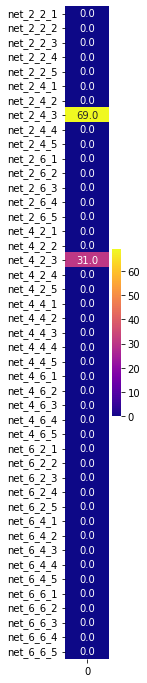

In [53]:
df = pd.DataFrame(model_probs * 100.0, index=net_names)
plt.figure(figsize=(1, 12)) # 8, 4 or 6, 8
sns.heatmap(df, cmap='plasma', annot=True, fmt='.1f') # annot=True
plt.yticks(rotation=0, va='center')
plt.show()
# first run: 
# net_2_4_3 51.2%
# net_4_2_3 48.8%
# second run (new simulation data): 
# net_2_4_3 69.0%
# net_4_2_3 31.0%

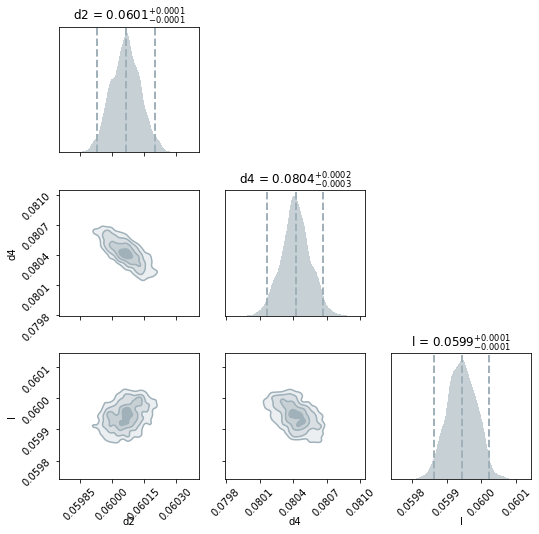

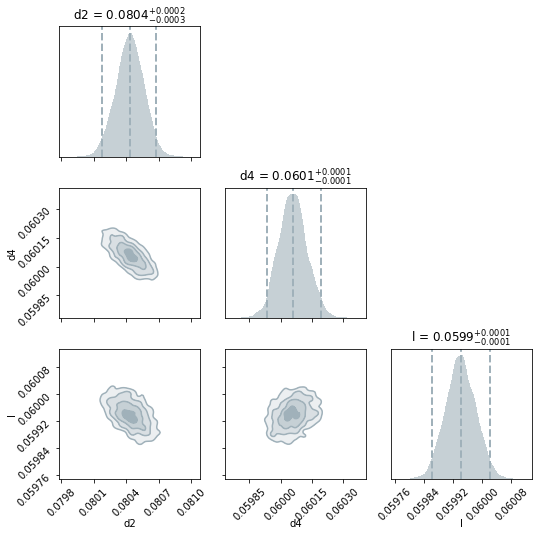

In [54]:
est = est_res_int[7]
me.plots.est_corner_kernel_plot(est)

est = est_res_int[17]
me.plots.est_corner_kernel_plot(est)
# first run estimated rates:
# net_4_2_3: d2=0.076, d4=0.063, l=0.060
# second run estimated rates (new simulation data):
# net_4_2_3: d2=0.080, d4=0.060, l=0.060

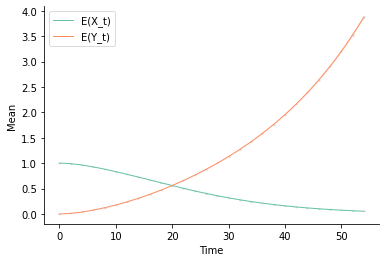

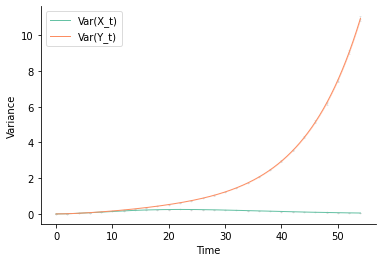

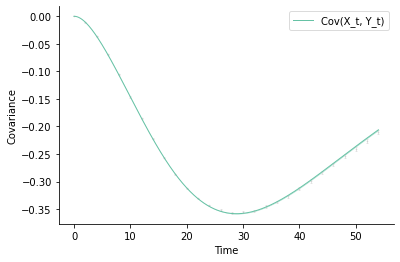

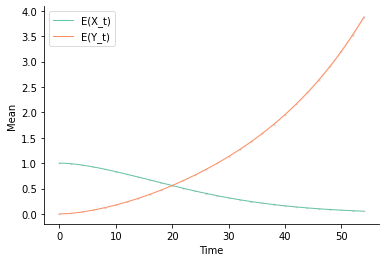

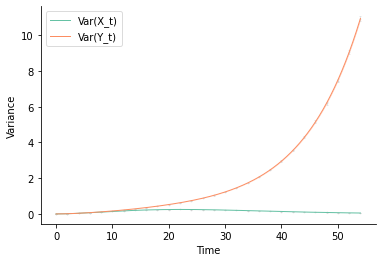

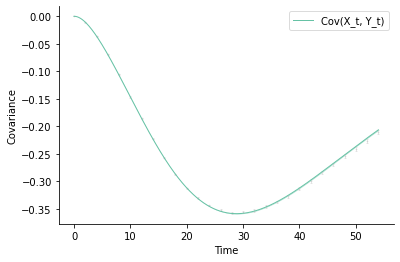

In [55]:
est = est_res_int[7]
me.plots.est_bestfit_mean_plot(est)
me.plots.est_bestfit_variance_plot(est)
me.plots.est_bestfit_covariance_plot(est)

est = est_res_int[17]
me.plots.est_bestfit_mean_plot(est)
me.plots.est_bestfit_variance_plot(est)
me.plots.est_bestfit_covariance_plot(est)

##### Estimation of external simulated data

In [67]:
d = {
# model set
'model_set': models,

# data/model settings
'data': data_ext,
'mean_only': False, # True or False

# nested sampling settings
'nlive':                    250, # 250 # 1000
'tolerance':                0.1, # 0.1 (COARSE) # 0.05 # 0.01 (NORMAL)
'bound':                    'multi',
'sample':                   'unif'
}

est_res_ext = me.select_models(d, parallel={'do':False})

In [68]:
net_names = [est.net.net_name for est in est_res_ext]
model_probs = me.selection.compute_model_probabilities(est_res_ext)
print(net_names.index('net_4_2_3')) # true model
print(net_names.index('net_2_4_3')) # symmetric true model

17
7


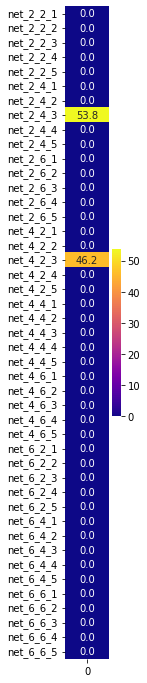

In [69]:
df = pd.DataFrame(model_probs * 100.0, index=net_names)
plt.figure(figsize=(1, 12)) # 8, 4 or 6, 8
sns.heatmap(df, cmap='plasma', annot=True, fmt='.1f') # annot=True
plt.yticks(rotation=0, va='center')
plt.show()

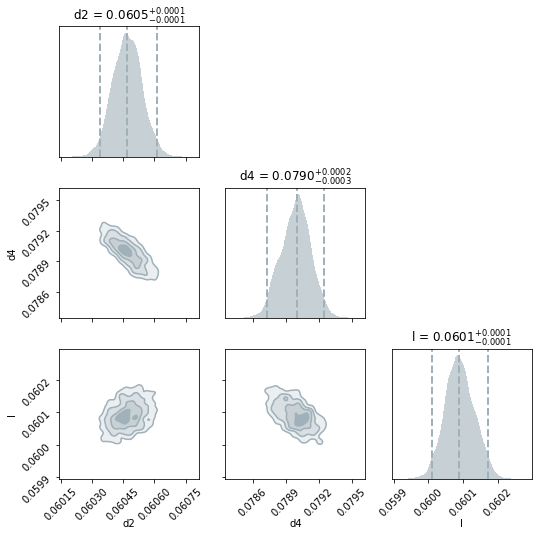

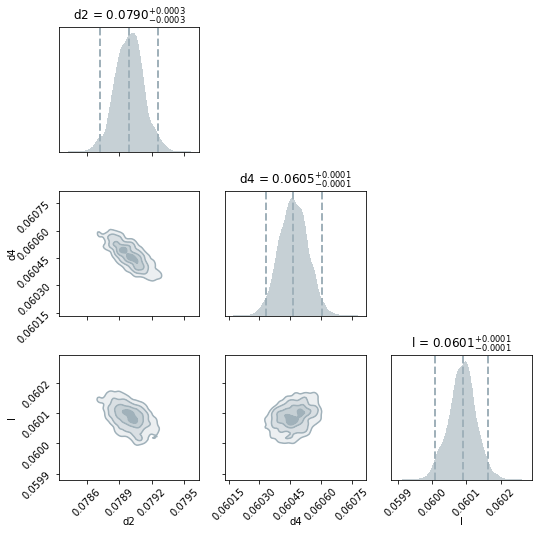

In [70]:
est = est_res_ext[7]
me.plots.est_corner_kernel_plot(est)

est = est_res_ext[17]
me.plots.est_corner_kernel_plot(est)

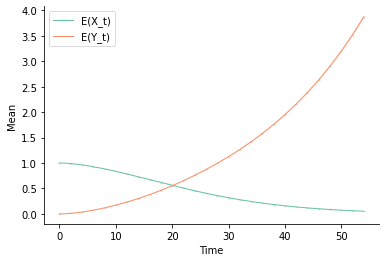

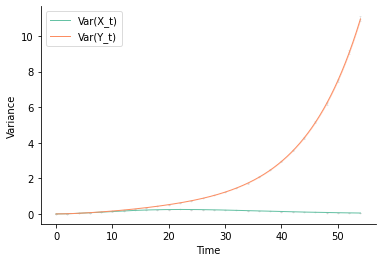

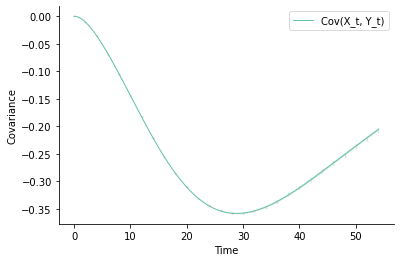

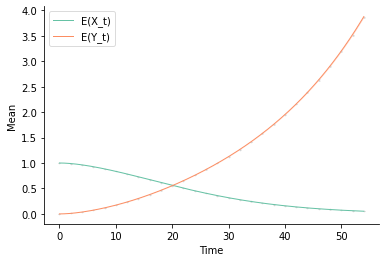

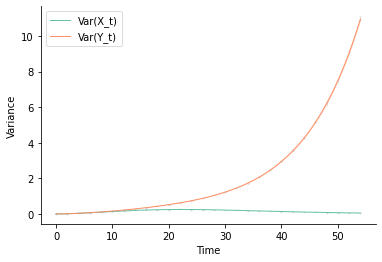

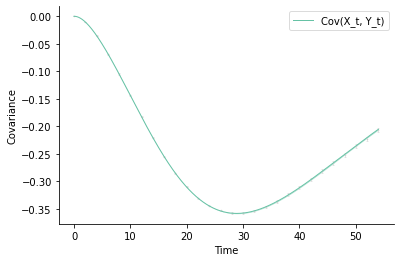

In [71]:
est = est_res_ext[7]
me.plots.est_bestfit_mean_plot(est)
me.plots.est_bestfit_variance_plot(est)
me.plots.est_bestfit_covariance_plot(est)

est = est_res_ext[17]
me.plots.est_bestfit_mean_plot(est)
me.plots.est_bestfit_variance_plot(est)
me.plots.est_bestfit_covariance_plot(est)